In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [54]:
# https://archive.ics.uci.edu/ml/datasets/Air+quality
data = pd.read_csv('AirQualityUCI.csv', header=0, delimiter=';', decimal=",")

In [57]:
co_gt = pd.to_numeric(data.ix[:, 'RH'].values.tolist())
co_gt = np.clip(co_gt, 0, 100) / 100

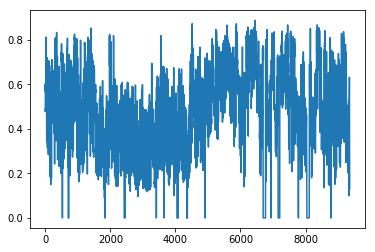

In [58]:
plt.figure()
plt.plot(co_gt)
plt.show()

In [59]:
WINDOW = 12
STEP = 1
FORECAST = 1

X, Y = [], []
for i in range(0, len(co_gt), STEP): 
    try:
        x = co_gt[i:i+WINDOW]
        y = co_gt[i+WINDOW+FORECAST]
    except:
        continue
        
    X.append(x)
    Y.append(y)
    
X, Y = np.array(X), np.array(Y)
print X.shape, Y.shape

(9458, 12) (9458,)


In [60]:
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.layers import Merge, Input, concatenate, GaussianNoise
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Convolution1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses

from sklearn.metrics import r2_score

In [76]:
def plot_history(history):
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
def get_model(x1):
    main_input = Input(shape=(x1, ), name='main_input')
    x = GaussianNoise(0.01)(main_input)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation = "linear", name = "out")(x)
    final_model = Model(inputs=[main_input], outputs=[output])
    final_model.compile(optimizer=Adam(lr=0.01, amsgrad=True),  loss='mse')
    return final_model


def get_recurrent_model(x1):
    main_input = Input(shape=(x1, 1,), name='main_input')
    x = GaussianNoise(0.01)(main_input)
    x = LSTM(15, return_sequences = False)(x)
    output = Dense(1, activation = "linear", name = "out")(x)
    final_model = Model(inputs=[main_input], outputs=[output])
    final_model.compile(optimizer=Adam(lr=0.01, amsgrad=True),  loss='mse')
    return final_model

def get_convo_model(x1):
    main_input = Input(shape=(x1, 1, ), name='main_input')
    x = GaussianNoise(0.01)(main_input)
    x = Convolution1D(32, 3, activation = 'relu')(main_input)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    output = Dense(1, activation = "linear", name = "out")(x)
    final_model = Model(inputs=[main_input], outputs=[output])
    final_model.compile(optimizer=Adam(lr=0.01, amsgrad=True),  loss='mse')
    return final_model

In [80]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=100, min_lr=0.000001, verbose=0)
checkpointer = ModelCheckpoint(filepath="testtest.hdf5", verbose=0, save_best_only=True)

TRAIN_START = 0
TRAIN_END = 24*90
TEST_START = TRAIN_END+1
TEST_END = TEST_START + 24*7

X_train, X_test = X[TRAIN_START:TRAIN_END], X[TEST_START:TEST_END]
Y_train, Y_test = Y[TRAIN_START:TRAIN_END], Y[TEST_START:TEST_END]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# model = get_model(WINDOW)
# model = get_convo_model(WINDOW)
model = get_recurrent_model(WINDOW)
model.summary()

history = model.fit(X_train, Y_train, 
              epochs = 10, 
              batch_size = 64, 
              verbose=1, 
              validation_data=(X_test, Y_test),
              callbacks=[reduce_lr, checkpointer],
              shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 12, 1)             0         
_________________________________________________________________
gaussian_noise_14 (GaussianN (None, 12, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                1020      
_________________________________________________________________
out (Dense)                  (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Train on 2160 samples, validate on 168 samples
Epoch 1/10
2160/2160 [==============================] - 2s 967us/step - loss: 0.0369 - val_loss: 0.0126
Epoch 2/10
2160/2160 [==============================] - 2s 701us/step - loss: 0.0143 - val_loss: 0.0087
Epoch 3/10
2160/2

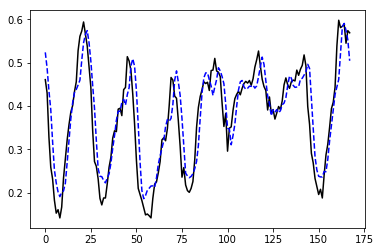

In [81]:
model.load_weights('testtest.hdf5')
pred = model.predict(X_test)
predicted = pred
original = Y_test

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data', linestyle = '--')
plt.show()

In [82]:
print 'MSE', np.mean(np.square(predicted - original))
print 'MAE', np.mean(np.abs(predicted - original))
print 'R2', r2_score(original, predicted)

MSE 0.02496751714916661
MAE 0.12728393014876038
R2 0.7922341062692797
